# Machine Learning in der Anwendung Software Projekt

## 1. Einleitung zum Business Case

Pro Jahr kommt es im Euro Raum zu einem Schaden von 1,8 Milliarden Euro durch Kreditkartenbetrug. [@ECB2023] Um diesen Schaden zu minimieren, werden in diesem Projekt verschiedene Machine Learning Algorithmen auf einen Datensatz angewendet, um Kreditkartenbetrug zu erkennen. 

In [3]:
#Installieren der benötigten Pakete und Bibliotheken
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [182]:
import pandas as pd 
import numpy as np
import matplotlib 
from matplotlib import warnings
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, make_scorer, ConfusionMatrixDisplay

In [26]:
# Warnungen ausblenden -> häufig bei Visualisierungen wegen alter Versionen
warnings.filterwarnings('ignore')

# Keine Begrenzungen bei anzeigten Spalten in einem DataFrame
pd.set_option('display.max_columns', None)

In [27]:
# Bereitstellen von Kaggle API-Keys für das Herunterladen von Datensätzen
os.environ['KAGGLE_USERNAME'] = 'aminsch'
os.environ['KAGGLE_KEY'] = 'f895e44fc1299d87e9fb4b7f25af0d9a'


# Anfrage an die Kaggle API zum Herunterladen von dem Datensatz mit Speicherung in den Ordner Input, welcher in der geschaffenen Ordner-Struktur eingepflegt wird.
# Durch die verwendung von !kaggle ist die Verwendung von der Kaggle-Api ohne vorherige importieren von der Kaggle Bibliothek möglich.
!kaggle datasets download -d mlg-ulb/creditcardfraud -p "./data/input" --unzip



100%|██████████████████████████████████████| 66.0M/66.0M [00:04<00:00, 21.5MB/s]
100%|██████████████████████████████████████| 66.0M/66.0M [00:04<00:00, 15.6MB/s]


## Data Analysis

In [28]:
#Path wird einmal zental definiert
data_path = "data/input/creditcard.csv"

In [29]:
# Einlesen der Daten mit Pandas in ein DataFrame
df = pd.read_csv(data_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [30]:
# Anzeigen von weiteren Informationen, wie Durchschnitt, Standardabweichung, Minimum, Maximum, etc.
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [31]:
# Liste aller Classifications-Klassen in STRING-Format als Dictionary für die Übersichtlichkeit bei Visualisierungen
class_definitions = {
    "0": "no_fraud",
    "1": "fraud"
}


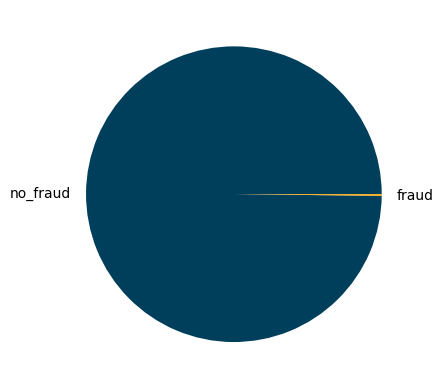

[{'Name': 'no_fraud', 'Anzahl': 284315, 'Prozent': 99.83},
 {'Name': 'fraud', 'Anzahl': 492, 'Prozent': 0.17}]

In [32]:
# Funktion zum Ausgeben der Anzahl der Datenpunkte pro Klasse und anschliepßender Visualisierung als Pie-Chart
def datasetBalance(input_path: pathlib.Path, visualize: bool = False):
    output_list = []
    
    label_list = list(class_definitions.values())
    pie_value = []
    color_list = ['#003f5c','#ffa600']

   
    total_count = len(df)
    
    for class_name, class_label in class_definitions.items():
        data_count = len(df[df["Class"] == int(class_name)])
        data_dict = dict({'Name': class_label, 'Anzahl': data_count, 'Prozent': round((data_count/total_count)*100, 2)})
        output_list.append(data_dict)
        
        if visualize:
            pie_value.append(data_count)

    if visualize:
        plt.pie(pie_value, labels=label_list, colors=color_list)
        plt.show()
    
    return output_list
datasetBalance(input_path=data_path, visualize=True)

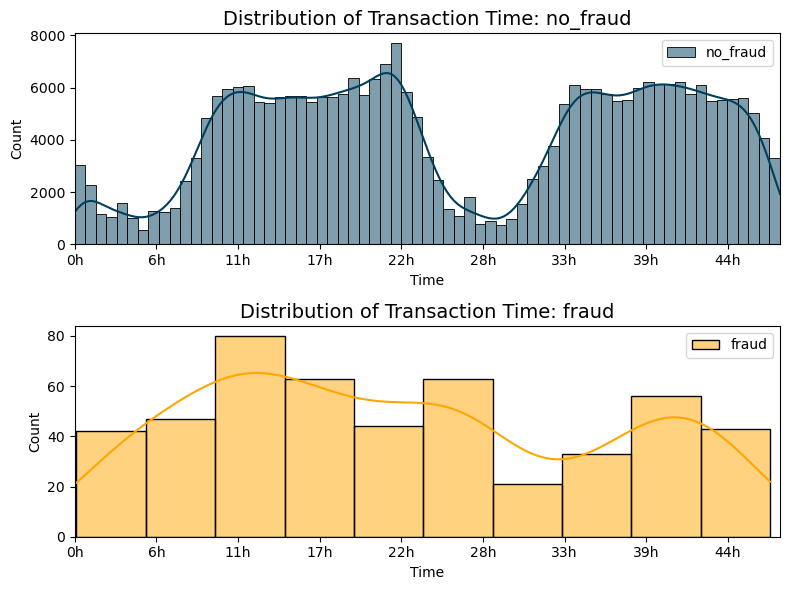

In [33]:
# Funktion zum Ausgeben der Anzahl der Datenpunkte pro Klasse und anschliepßender Visualisierung als Bar-Chart, um die Verteilung der zeitlichen Datenpunkte besser zuerkennen
def plotTransactionTimeDistribution(input_path: pathlib.Path = data_path):
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
    
    # Umwandlungsfunktion für die Achsenbeschriftung, da die Zeit in Sekunden angegeben ist
    def seconds_to_hours(x, pos):
        return '{:.0f}h'.format(x / 3600)  # 3600 Sekunden entsprechen 1 Stunde
    
    formatter = FuncFormatter(seconds_to_hours)
    
    for idx, (class_val, class_label) in enumerate(class_definitions.items()):
        time_values = df[df['Class'] == int(class_val)]['Time']
        if class_label == 'no_fraud':
            color = '#003f5c'
        else:
            color = '#ffa600'
        
        # Verwendung von histplot für das Zeichnen
        sns.histplot(time_values, kde=True, ax=axes[idx], color=color, label=class_label)
        
        axes[idx].set_title(f'Distribution of Transaction Time: {class_label}', fontsize=14)
        axes[idx].set_xlim([min(df['Time']), max(df['Time'])])
        axes[idx].legend()
        
        # Anwenden des Formatters auf die x-Achse
        axes[idx].xaxis.set_major_formatter(formatter)
    
    plt.tight_layout()
    plt.show()

plotTransactionTimeDistribution()

In [34]:
#Splitte die Daten in Trainings- und Testdaten -> 80% Trainingsdaten, 20% Testdaten
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [35]:
# Features und Labels trennen -> Class ist das Label, alle anderen Spalten sind Features
X_train = train_df.drop(['Class'], axis=1) 
y_train = train_df['Class']
X_test = test_df.drop(['Class'], axis=1)
y_test = test_df['Class']

In [36]:
# XGBoost Klassifizierer initialisieren
xgb_clf = XGBClassifier(use_label_encoder=False)

In [37]:
# Parameter Grid definieren
param_grid = {
    'max_depth': [4, 6, 8], # Maximale Tiefe eines Baumes
    'min_child_weight': [1, 5, 10], # Minimale Anzahl an Datenpunkten in einem Blatt
    'subsample': [0.6, 0.8, 1.0], # Anteil der Datenpunkte, die für das Training verwendet werden
    'colsample_bytree': [0.6, 0.8, 1.0], # Anteil der Features, die für das Training verwendet werden
    'n_estimators': [100, 200, 300], # Anzahl der Bäume
    'learning_rate': [0.01, 0.1, 0.2], # Lernrate
    'scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)]  # Gewichtung der Klassen
}


In [38]:
# GridSearchCV initialisieren
grid_clf = GridSearchCV(xgb_clf, param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1) # cv = Anzahl der Folds, n_jobs = Anzahl der Prozesse # scoring = Metrik, die optimiert werden soll # verbose = Ausgabe von Informationen während des Trainings

In [44]:

# GridSearchCV ausführen Vorgang dauert circa 13 Minuten
grid_clf.fit(X_train, y_train)

# Die besten Parameter anzeigen
print("Beste Parameter:", grid_clf.best_params_)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


Beste Parameter: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 10, 'n_estimators': 300, 'scale_pos_weight': 577.2868020304569, 'subsample': 1.0}


### Aufschlüsslung der Gridsearch:
Fitting 3 folds: GridSearchCV verwendet Kreuzvalidierung (Cross-Validation), um die Generalisierbarkeit der Modelle zu bewerten. "3 folds" bedeutet, dass es die Kreuzvalidierung mit 3 verschiedenen Unterteilungen (Folds) der Daten durchführt. Für jeden Fold wird ein Teil der Daten als Trainingsset und ein anderer Teil als Validierungsset verwendet. Das Verfahren wird so gestaltet, dass jeder Teil der Daten einmal als Validierungsset dient.

for each of 729 candidates: Wie bereits berechnet, gibt es 729 verschiedene Kombinationen von Parametern, die getestet werden (basierend auf den verschiedenen Werten, die Sie für jeden Parameter angegeben haben).

totalling 2187 fits: Da für jede der 729 Kandidaten-Kombinationen das Modell mit 3 verschiedenen Folds trainiert und validiert wird, ergibt das insgesamt 
729 Kandidaten × 3 Folds = 2187

Also wird jedes mögliche Modell, das durch eine einzigartige Kombination der Parameter definiert ist, dreimal trainiert und validiert, wobei jedes Mal ein unterschiedlicher Datenabschnitt als Validierungsset verwendet wird. Das gesamte Verfahren umfasst 2187 solcher Anpassungen/Trainings- und Validierungsdurchläufe.

### Erklärung der besten Parameterkombination:

#### colsample_bytree: 
Ein Wert von 0.6 bedeutet, dass in jedem Schritt des Algorithmus 60% der Features zufällig ausgewählt werden, um Überanpassung (Overfitting) zu vermeiden und die Diversität unter den Bäumen zu erhöhen.

#### learning_rate: 
Ein Lernrate von 0.1 bedeutet, dass der Algorithmus in jedem Schritt nur 10% der Korrekturen anwendet, die der Gradient Boosting Algorithmus vorschlägt. Dies hilft, die Robustheit des Modells zu verbessern, kann aber auch bedeuten, dass mehr Bäume (oder "n_estimators") benötigt werden, um zu konvergieren.

#### max_depth: 
Eine maximale Tiefe von 6 begrenzt die Komplexität jedes einzelnen Baumes und hilft, das Overfitting zu verhindern.

#### min_child_weight: 
Ein Wert von 10 bedeutet, dass jeder Knoten, der weniger als 10 Instanzen repräsentiert, nicht weiter aufgeteilt wird. Dies dient ebenfalls dazu, das Modell zu regulieren und Überanpassung zu verhindern.

#### n_estimators: 
300 Bäume in diesem Fall bedeuten, dass der Algorithmus versucht, das Lernen nach der Erstellung von 300 Bäumen zu stoppen. Eine höhere Anzahl von Bäumen kann zu besseren Ergebnissen führen, aber auch das Risiko des Overfitting erhöhen und die Berechnungszeit verlängern.

#### scale_pos_weight: 
Dieser Parameter wird in unausgeglichenen Klassifizierungsproblemen verwendet, um das Gleichgewicht zwischen positiven und negativen Gewichten zu korrigieren. Hier scheint es, dass die positive Klasse viel seltener ist als die negative (etwa 577 Mal seltener), was darauf hinweist, dass es sich um ein stark unausgeglichenes Problem handelt.

#### subsample: 
Ein Wert von 1.0 bedeutet, dass das gesamte Trainingsset verwendet wird. Dieser Parameter kann zusammen mit colsample_bytree helfen, die Varianz des Modells zu verringern und Overfitting zu kontrollieren.

In [45]:
# Bestes Modell aus GridSearchCV nehmen
best_xgb_clf = grid_clf.best_estimator_

# Vorhersagen machen geht schnell da die perfekten Parameter bereits durch die GridSearchCV gefunden wurden
predictions = best_xgb_clf.predict(X_test)

In [46]:
# Bewertungsmetriken ausgeben
print('Accuracy:', accuracy_score(y_test, predictions))
print('Recall:', recall_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('F1 Score:', f1_score(y_test, predictions))

Accuracy: 0.9995786664794073
Recall: 0.8163265306122449
Precision: 0.9302325581395349
F1 Score: 0.8695652173913043


### Accuracy (Genauigkeit): 0.9995786664794073
Die Genauigkeit misst den Anteil der insgesamt korrekt vorhergesagten Fälle (sowohl wahre Positiv- als auch Negativmeldungen) an allen Vorhersagen. Eine Genauigkeit von nahezu 1 
bedeutet, dass fast alle Vorhersagen korrekt sind. In diesem Fall hat das Modell eine sehr hohe Genauigkeit, was darauf hinweist, dass es die meisten der Fälle richtig klassifiziert, dies weist auf ein Overfitting hin.

### Recall (Sensitivität): 0.8163265306122449
Recall misst den Anteil der tatsächlichen Positivfälle, die korrekt als solche erkannt wurden. Ein Recall von etwa 0,83 bedeutet, dass das Modell ca. 82% der tatsächlichen Fraud-Fälle korrekt identifiziert hat. Während dies hoch ist, bedeutet es auch, dass etwa 18% der Fraud-Fälle vom Modell nicht erkannt wurden.

### Precision (Präzision): 0.9302325581395349
Precision gibt an, welcher Anteil der als "Fraud" vorhergesagten Fälle tatsächlich "Fraud" war. Eine Präzision von etwa 0,93 bedeutet, dass von den als "Fraud" klassifizierten Transaktionen tatsächlich 93% betrügerisch sind. Dies ist besonders wichtig in Anwendungen, wo falsche Positive (fälschlicherweise als Fraud klassifizierte Transaktionen) ernsthafte Konsequenzen haben könnten.

#### F1 Score: 0.8695652173913043
Der F1 Score ist das harmonische Mittel aus Precision und Recall. Es gibt ein Maß dafür, wie gut das Präzisions- und Rückrufgleichgewicht ist. Ein F1 Score von etwa 0,87 ist ziemlich hoch, was darauf hinweist, dass das Modell ein gutes Gleichgewicht zwischen Recall und Precision hat.

In [47]:
# Wirkliche Klassen und Vorhersagen
y_true = y_test  # Angenommen, y_test ist Ihr wahres Label für den Testdatensatz
y_pred = best_xgb_clf.predict(X_test)


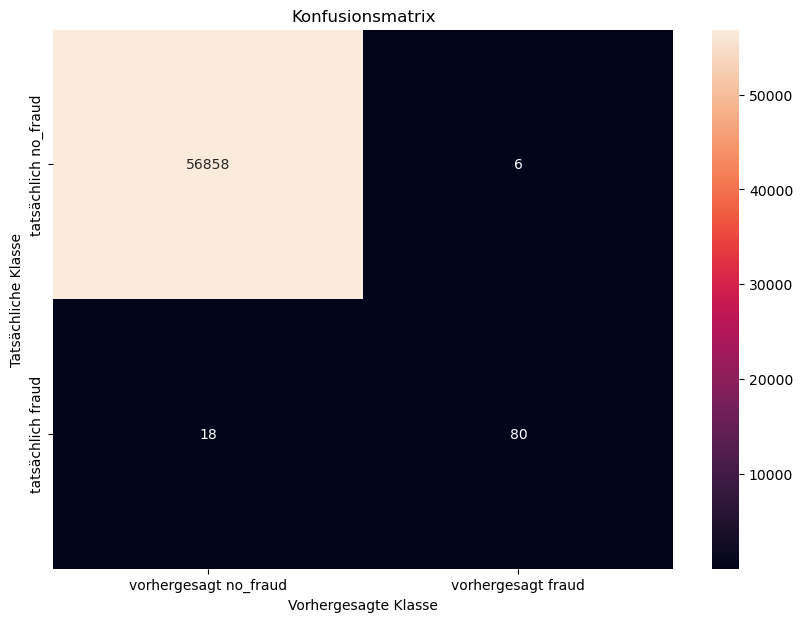

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



In [48]:
# Konfusionsmatrix und Bericht anzeigen
conf_mat = confusion_matrix(y_true, y_pred)
conf_mat_df = pd.DataFrame(
    conf_mat, 
    index=['tatsächlich no_fraud', 'tatsächlich fraud'], 
    columns=['vorhergesagt no_fraud', 'vorhergesagt fraud']
)
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat_df, annot=True, fmt='g')
plt.title('Konfusionsmatrix')
plt.ylabel('Tatsächliche Klasse')
plt.xlabel('Vorhergesagte Klasse')
plt.show()
print(classification_report(y_true, y_pred))


In [49]:
# Das beste Modell aus der Grid-Suche wird genommen
best_xgb_clf = grid_clf.best_estimator_

# Verzeichnis wird überprüft und dann ggbf erstellt
models_directory = 'models'
if not os.path.exists(models_directory):
    os.makedirs(models_directory)

# Pfad, unter dem das Modell gespeichert werden soll.
model_path = os.path.join(models_directory, 'best_xgboost_model.json')

# Speichern Sie das Model as JSON.
best_xgb_clf.save_model(model_path)

print(f"Das Modell wurde erfolgreich als '{model_path}' gespeichert.")

Das Modell wurde erfolgreich als 'models/best_xgboost_model.json' gespeichert.


# Versuch Recall zuverbessern durch early stopping und custom recall 

In [198]:
def custom_asymmetric_loss(preds, dtrain):
    labels = dtrain.get_label()
    # Definition des Gewichts, das Falschpositiven und Falschnegativen zugeordnet wird
    false_pos_weight = 1.0  
    false_neg_weight = 5.0

    # Die Vorhersagen in Wahrscheinlichkeiten umwandeln 
    preds = 1.0 / (1.0 + np.exp(-preds))
    # Gradient berechnen (erste Ableitung)
    grad = preds - labels
    
    # Hier passen wir die Gradienten an, um Falschpositiven ein höheres Gewicht zu geben
    grad[labels == 0] *= false_pos_weight
    grad[labels == 1] *= false_neg_weight

    # Hesse berechnen (zweite Ableitung)
    hess = preds * (1.0 - preds)

    # Hier gewichten wir auch die Hesses, um der asymmetrischen Natur gerecht zu werden (siehe oben)
    hess[labels == 0] *= false_pos_weight
    hess[labels == 1] *= false_neg_weight

    return grad, hess


In [199]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [200]:
eval_set = [(dtrain, 'train'), (dtest, 'eval')]

In [201]:

def custom_recall(preds, dtrain): 
    labels = dtrain.get_label()
    # Vorhersagen in binäre Werte umwandeln, 0.5 als Schwellenwert (alles über 0.5 wird als 1 gewertet)
    preds_binary = [1 if i > 0.5 else 0 for i in preds]
    # Recall berechnen (Anzahl der korrekt vorhergesagten positiven Fälle / Anzahl der tatsächlich positiven Fälle)
    recall_value = recall_score(labels, preds_binary)
    # XGBoost erwartet ein Tupel mit dem Namen der Metrik und dem Wert der Metrik
    return 'custom_recall', recall_value

In [202]:
custom_recall_scorer = make_scorer(custom_recall)

In [203]:
best_params = {k: v for k, v in grid_clf.best_params_.items()}

In [208]:
bst = xgb.train(
    params=best_params,
    dtrain=dtrain, 
    num_boost_round=300, # Anzahl der Iterationen
    evals=eval_set, # Die Daten, die für die Evaluation verwendet werden sollen
    obj=custom_asymmetric_loss, # Loss-Funktion, die wir optimieren wollen
    feval=custom_recall, # Die Metrik, die wir optimieren wollen
    maximize=True,  # Wir maximieren den Recall
    early_stopping_rounds= 50 # Training wird abgebrochen, wenn sich der Recall nicht mehr verbessert
)

print(f"Modell hat nach {bst.best_iteration} Iterationen mit early stopping angehalten.")


[0]	train-rmse:0.23653	train-custom_recall:0.81472	eval-rmse:0.23652	eval-custom_recall:0.82653
[1]	train-rmse:0.02492	train-custom_recall:0.80964	eval-rmse:0.02436	eval-custom_recall:0.81633
[2]	train-rmse:0.19184	train-custom_recall:0.80711	eval-rmse:0.19175	eval-custom_recall:0.79592
[3]	train-rmse:0.37315	train-custom_recall:0.81980	eval-rmse:0.37308	eval-custom_recall:0.82653
[4]	train-rmse:0.54107	train-custom_recall:0.81980	eval-rmse:0.54100	eval-custom_recall:0.82653
[5]	train-rmse:0.69852	train-custom_recall:0.81980	eval-rmse:0.69844	eval-custom_recall:0.81633
[6]	train-rmse:0.84747	train-custom_recall:0.81980	eval-rmse:0.84740	eval-custom_recall:0.77551
[7]	train-rmse:0.98939	train-custom_recall:0.81980	eval-rmse:0.98931	eval-custom_recall:0.76531
[8]	train-rmse:1.12574	train-custom_recall:0.81726	eval-rmse:1.12564	eval-custom_recall:0.79592
[9]	train-rmse:1.25735	train-custom_recall:0.81980	eval-rmse:1.25728	eval-custom_recall:0.78571
[10]	train-rmse:1.38496	train-custom_rec

In [205]:
pred_probs = bst.predict(dtest)

preds = np.where(pred_probs > 0.5, 1, 0)


In [206]:
# Bewertungsmetriken ausgeben
print('Accuracy:', accuracy_score(y_test, preds))
print('Recall:', recall_score(y_test, preds))
print('Precision:', precision_score(y_test, preds))
print('F1 Score:', f1_score(y_test, preds))

Accuracy: 0.9996488887328394
Recall: 0.826530612244898
Precision: 0.9642857142857143
F1 Score: 0.8901098901098902


## Eregvebnisse mit early stopping = 50 und Lossfunction mit 5 Facher Gewichtung
### Accuracy: 0.9996488887328394

### Recall: 0.826530612244898

### Precision: 0.9642857142857143

### F1 Score: 0.8901098901098901

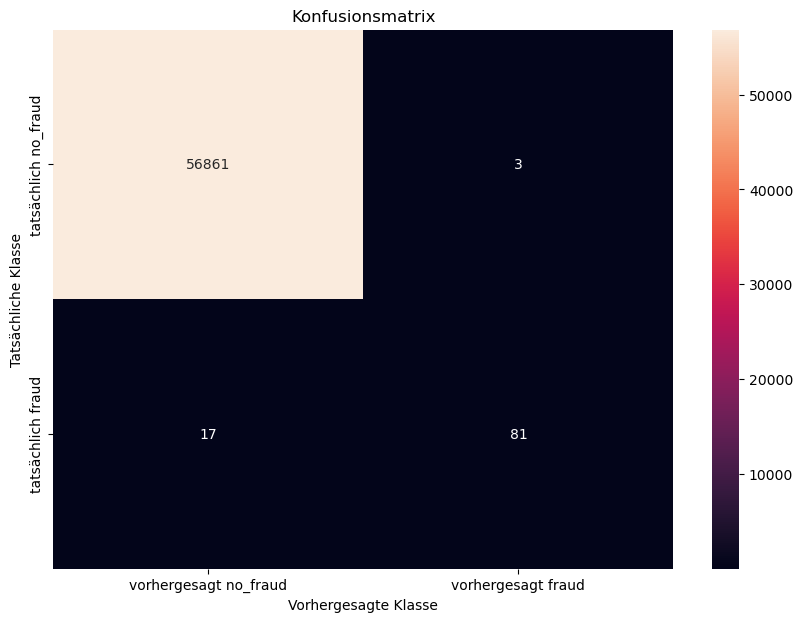

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.83      0.89        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



In [207]:
y_pred = preds

conf_mat = confusion_matrix(y_true, y_pred)

conf_mat_df = pd.DataFrame(
    conf_mat,
    index=['tatsächlich no_fraud', 'tatsächlich fraud'],
    columns=['vorhergesagt no_fraud', 'vorhergesagt fraud']
)

plt.figure(figsize=(10,7))
sns.heatmap(conf_mat_df, annot=True, fmt='g')
plt.title('Konfusionsmatrix')
plt.ylabel('Tatsächliche Klasse')
plt.xlabel('Vorhergesagte Klasse')
plt.show()

# Klassifizierungsbericht anzeigen
print(classification_report(y_true, y_pred))

In [210]:
models_directory = 'models'
if not os.path.exists(models_directory):
    os.makedirs(models_directory)

# Pfad, unter dem das Modell gespeichert werden soll.
model_path = os.path.join(models_directory, 'best_model.json')

# Speichern Sie das Model as JSON.
bst.save_model(model_path)

print(f"Das Modell wurde erfolgreich als '{model_path}' gespeichert.")

Das Modell wurde erfolgreich als 'models/best_model.json' gespeichert.
